In [46]:
import sys
import affine
import itertools
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import seaborn as sns
from skimage.filters import threshold_otsu
from skimage import exposure
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from rasterio.features import shapes
from scipy.ndimage import gaussian_filter
from shapely.geometry import shape, Point, LineString
from shapely.ops import nearest_points


def RMSE(data):
    return np.sqrt((data ** 2).mean())


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


def points_along_line(line_gdf, dist=5):    

    out = [] 
    
    # create points every 30 meters along the line
    for i, distance in enumerate(range(0, int(line_gdf.length), dist)):
        point = line_gdf.interpolate(distance)
        out.append(point[0])
        
    subpixel_points = gpd.GeoDataFrame(geometry=out, crs=line_gdf.crs)
    return subpixel_points


def simulated_waterlines(synthetic_ds, agg_factor = 30, thresh = 0):
    
    # Aggregate data to new resolution
    synthetic_coarse = synthetic_ds.coarsen(x=agg_factor, y=agg_factor, boundary='trim').mean()
    
    # Set up affine object for new resolution
    aggregated_affine = affine.Affine(1 * agg_factor,       # width of pixel
                                      0,                    # row rotation  
                                      0,                    # x coord of upper left corner of upper left pixel
                                      0,                    # column rotation
                                      -1 * agg_factor,      # height of pixel
                                      0)                    # y coord of upper left corner of upper left pixel

    # Compute NDWI on aggregate data
    synthetic_coarse['NDWI'] = (synthetic_coarse.green - synthetic_coarse.nir) / (synthetic_coarse.green + synthetic_coarse.nir)

    # Extract shoreline along true land-water validation boundary
    val_shoreline_gdf = SpatialTools.contour_extract(z_values=[0.5],
                                       ds_array=synthetic_ds.land_water,
                                       ds_crs='EPSG:4326',
                                       ds_affine=affine.Affine(1, 0, 0, 0, -1, 0),
                                       output_shp=f'validation_shoreline.shp',
                                       min_vertices=2,
                                       verbose=False)

    # Extract subpixel shoreline along aggregated dataset based on water index
    subpixel_shoreline_gdf = SpatialTools.contour_extract(z_values=[thresh],
                                                ds_array=synthetic_coarse.NDWI,
                                                ds_crs='EPSG:4326',
                                                ds_affine=aggregated_affine,
                                                output_shp=f'waterline_synthetic.shp',
                                                min_vertices=2,
                                                verbose=False)

    # Threshold to water index value
    ds_bool = (synthetic_coarse.NDWI > thresh)

    # Polygonise and filter to keep only values = 1
    geoms = list(shapes(ds_bool.values.astype(np.int16), transform=aggregated_affine))
    geoms = [(a, b) for (a, b) in geoms if b == 1.0]
    geoms_shape = [shape(a) for (a, b) in geoms]
    data = [b for (a, b) in geoms]

    # Covert to a geodataframe of blocky waterlines
    blocky_shoreline_gdf = gpd.GeoDataFrame(data={'value': data}, geometry = geoms_shape)
    blocky_shoreline_gdf['geometry'] =  [LineString(i.coords) for i in blocky_shoreline_gdf.geometry.exterior]
    
    # Return waterlines
    return val_shoreline_gdf, subpixel_shoreline_gdf, blocky_shoreline_gdf, synthetic_coarse

# Import external dea-notebooks functions using relative link to Scripts directory
sys.path.append('/g/data/r78/rt1527/dea-notebooks/10_Scripts')
import SpatialTools

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Example 1: rugged cliff coast

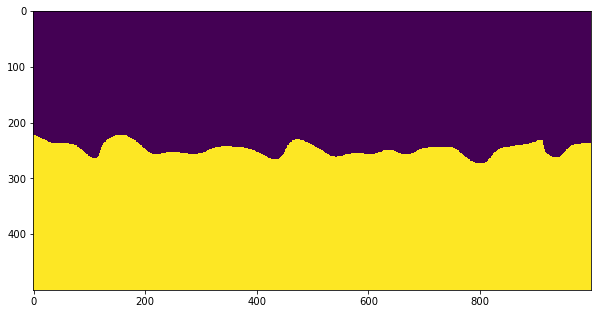

In [36]:
size_x, size = 1000, 500

gradient_array = np.repeat(np.linspace(0, 100, size), 
                           size_x, axis=0).reshape((size, size_x))

random_array = np.random.random((size, size_x))
gaussian_array = gaussian_filter(random_array, sigma=20)
gaussian_array = exposure.rescale_intensity(gaussian_array, out_range=(0, 100))

combined_array = (gradient_array * 2 + gaussian_array * 0.5) / 2.0
thresh_array = combined_array > combined_array.mean()

cliff_curve = thresh_array
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(thresh_array)

## Example 2: smooth beach curve

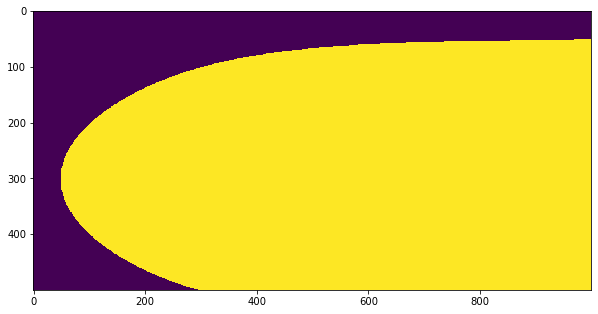

In [9]:
size, size_x = 500, 1000
empty_array = np.zeros(shape=(size, size_x))

x = np.linspace(0, size_x, 1000000)
y = (size - 250) *np.tanh(0.003 * x) ** 0.5

x2 = np.linspace(0, size_x, 1000000)
y2 = (-size + 250) *np.tanh(0.003 * x) ** 0.5

x = np.concatenate([x + 50, x2 + 50])
y = np.concatenate([y + 200, y2 + 200])

empty_array[-y.astype(int).clip(0, size - 1), 
             x.astype(int).clip(10, size_x - 1)] = 100


fig, ax = plt.subplots(figsize=(10, 10))
thresh_array = np.maximum.accumulate(empty_array.astype(int),1)
thresh_array = thresh_array==np.unique(thresh_array)[1]
thresh_array[0,:] = 0

beach_curve = thresh_array
ax.imshow(thresh_array)


array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

## Spectra

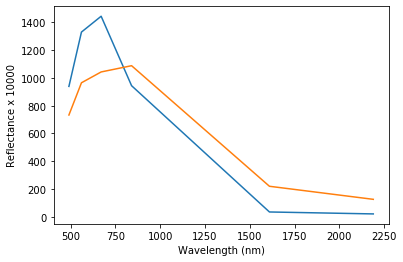

In [137]:
# water_spectra = [255, 191, 101, 87, 52, 59]  # deep blue water (Stockton Beach)
# water_spectra = [709, 1028, 544, 226, 205, 180]  # shallow blue water (Stockton Beach)
water_spectra = [1952, 2113, 1110, 405, 340, 282]  # shallow/sandy bottom tropical water (GBR)
# water_spectra = [929, 1226, 1537, 1401, 248, 175]  # highly turbid water (cambridge gulf)
# water_spectra = [805, 1226, 1537, 777, 86, 68]  # mod turbid water (cambridge gulf)


# land_spectra = [2370, 3326, 4165, 4899, 6259, 5992]  # bright yellow sand, dry (Stockton Beach)
# land_spectra = [1084, 1677, 2155, 2544, 2679, 1889]  # bright yellow sand, wet (Stockton Beach)
# land_spectra = [604, 888, 1280, 1633, 1628, 1372]  # exposed cliff (Stockton Beach)
land_spectra = [670, 857, 910, 1107, 1463, 1048]  # tidal mudflat, dry (Darwin)
# land_spectra = [490, 639, 670, 756, 108, 69]  # tidal mudflat, wet (Darwin)
# land_spectra = [417, 528,  345, 2061, 712, 304]  # mangrove vegetation (Darwin)


# water_spectra = [310, 262, 160, 125, 76, 60]  # deep water off Sydney
# land_spectra = [1905, 2298, 2670, 3421, 3874, 3491]  # artificial (Sydney)

water_spectra = [939,1330,1444,944,35,21]  # tidal mudflat 
land_spectra = [733,965,1043,1088,220,126]  # tidal mudflat 





# synthetic_ds['NDWI'] = (synthetic_ds.green - synthetic_ds.swir1) / (synthetic_ds.green + synthetic_ds.swir1)

plt.plot([490, 560, 670, 840, 1610, 2190], water_spectra, '-')
plt.plot([490, 560, 670, 840, 1610, 2190], land_spectra, '-')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance x 10000');


In [21]:
# out_perc_land = []
# out_ndwi = []
# out_mndwi = []
# out_awei_ns = []
# out_awei_sh = []
# out_wi = []

# for perc_land in np.arange(0, 1.0, 0.01):
    
#     mean_blue = np.mean(perc_land * land_spectra[0] + (1.0 - perc_land) * water_spectra[0])
#     mean_green = np.mean(perc_land * land_spectra[1] + (1.0 - perc_land) * water_spectra[1])
#     mean_red = np.mean(perc_land * land_spectra[2] + (1.0 - perc_land) * water_spectra[2])
#     mean_nir = np.mean(perc_land * land_spectra[3] + (1.0 - perc_land) * water_spectra[3])
#     mean_swir1 = np.mean(perc_land * land_spectra[4] + (1.0 - perc_land) * water_spectra[4])
#     mean_swir2 = np.mean(perc_land * land_spectra[5] + (1.0 - perc_land) * water_spectra[5])        
    
#     awei_ns = (4 * (mean_green * 0.0001 - mean_swir1 * 0.0001) - (0.25 * mean_nir * 0.0001 + 2.75 * mean_swir1 * 0.0001))
#     awei_sh = mean_blue * 0.0001 + 2.5 * mean_green * 0.0001 - 1.5 * (mean_nir * 0.0001 + mean_swir1 * 0.0001) - 0.25 * mean_swir2 * 0.0001
#     ndwi = (mean_green - mean_nir) / (mean_green + mean_nir)
#     mndwi = (mean_green - mean_swir1) / (mean_green + mean_swir1)
#     wi = (1.7204 + (171 * mean_green * 0.0001) + (3 * mean_red * 0.0001) - (70 * mean_nir * 0.0001) - (45 * mean_swir1 * 0.0001) - (71 * mean_swir2 * 0.0001))/15
    
#     out_perc_land.append(perc_land) 
#     out_ndwi.append(ndwi) 
#     out_mndwi.append(mndwi)
#     out_awei_ns.append(awei_ns)
#     out_awei_sh.append(awei_sh)
#     out_wi.append(wi)
    
# out_indices = pd.DataFrame({'Fractional pixel composition (% land)': out_perc_land, 
#                             'NDWI': out_ndwi, 'MNDWI': out_mndwi, 'AWEI_ns (Feyisa et al. 2014)': out_awei_ns, 
#                             'AWEI_sh (Feyisa et al. 2014)': out_awei_sh, 'WI (Fisher et al. 2016)': out_wi})

# fig, axes = plt.subplots(1, 2, figsize = (16, 8))
# out_indices.plot(x='Fractional pixel composition (% land)', y = 'NDWI', ax=axes[0])
# out_indices.plot(x='Fractional pixel composition (% land)', y = 'MNDWI', ax=axes[0])     
# out_indices.plot(x='Fractional pixel composition (% land)', y = 'AWEI_ns (Feyisa et al. 2014)', ax=axes[1])     
# out_indices.plot(x='Fractional pixel composition (% land)', y = 'AWEI_sh (Feyisa et al. 2014)', ax=axes[1])    
# out_indices.plot(x='Fractional pixel composition (% land)', y = 'WI (Fisher et al. 2016)', ax=axes[1])  
# axes[0].axvline(0.5, color='black', linestyle='--')
# axes[1].axvline(0.5, color='black', linestyle='--')
# axes[0].set_title('Non-linear')
# axes[1].set_title('Linear')
# axes[0].set_ylabel("Index value");


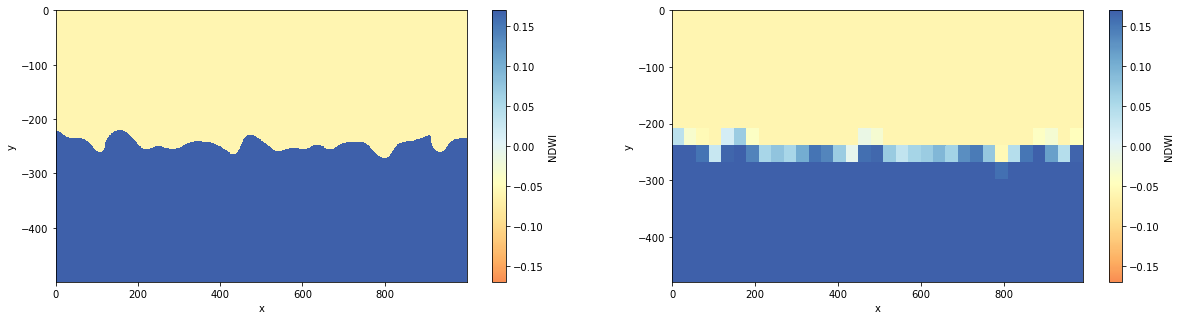

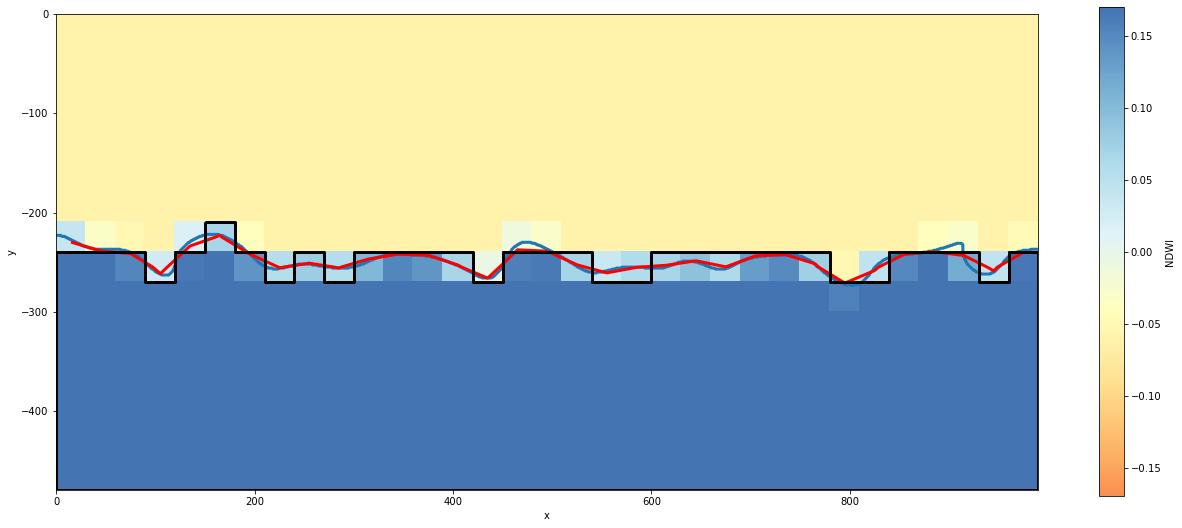

In [139]:
# Create 3D array with water and land spectra
water_3d = np.broadcast_to(np.array(water_spectra), (size_x, size, 6)).T
land_3d = np.broadcast_to(np.array(land_spectra), (size_x, size, 6)).T
spectra_array = np.where(thresh_array, water_3d, land_3d)

# Add validation land, water distribution as extra band
spectra_array = np.concatenate([~thresh_array[None,...], spectra_array])

# Convert to xarray format and rename bands
synthetic_array = xr.DataArray(spectra_array, dims=['variable', 'y', 'x'], coords={'x': np.arange(0, 1000, 1),
                                                                                   'y': np.arange(0, -500, -1)})
synthetic_ds = synthetic_array.to_dataset(dim='variable').rename({0: 'land_water', 1: 'blue', 2: 'green', 3: 'red', 
                                                                  4: 'nir', 5: 'swir1', 6: 'swir2'})

# Compute NDWI on validation dataset
synthetic_ds['NDWI'] = (synthetic_ds.green - synthetic_ds.nir) / (synthetic_ds.green + synthetic_ds.nir)      

# Extract contours
val_shoreline_gdf, subpixel_shoreline_gdf, blocky_shoreline_gdf, synthetic_coarse = simulated_waterlines(synthetic_ds, 
                                                                                                         agg_factor = 30, 
                                                                                                         thresh = 0.06)

# Plot validation and aggregated landscapes
fig, ax = plt.subplots(1, 2, figsize=(20.25, 5))
synthetic_ds.NDWI.plot(ax=ax[0], cmap=truncate_colormap(plt.get_cmap('RdYlBu'), 0.25, 0.93))
synthetic_coarse.NDWI.plot(ax=ax[1], cmap=truncate_colormap(plt.get_cmap('RdYlBu'), 0.25, 0.93))

# Plot results
fig, ax = plt.subplots(1, 1, figsize=(22, 9))
synthetic_coarse.NDWI.plot(ax=ax, cmap=truncate_colormap(plt.get_cmap('RdYlBu'), 0.25, 0.90))
val_shoreline_gdf.plot(ax=ax, linewidth=3)
subpixel_shoreline_gdf.plot(ax=ax, color='red', linewidth=3)
blocky_shoreline_gdf.plot(ax=ax, color='black', linewidth=3)


(array([264.,   5.,   4.,   1.,   2.,   6.,   0.,   4.,   2., 240.]),
 array([-0.12729124, -0.04673051,  0.03383023,  0.11439097,  0.1949517 ,
         0.27551244,  0.35607318,  0.43663391,  0.51719465,  0.59775539,
         0.67831612]),
 <a list of 10 Patch objects>)

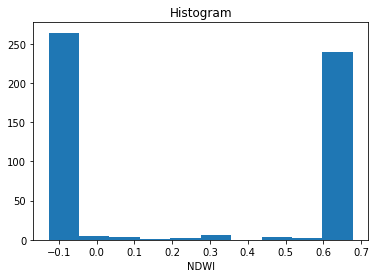

In [246]:
synthetic_coarse.NDWI.plot.hist()

In [64]:
landscape_scenarios = {'smooth curve': beach_curve, 'complex': cliff_curve}
thresh_scenarios = np.linspace(-0.3, 0.3, 61)

# resolution_scenarios = np.arange(2, 31, 1)
resolution_scenarios = [30]

spectra_scenarios = {          
                     'sandy_beach': {'water': [773, 908, 74,308,264,198], 
                                     'land': [2644,3689,4307,5181,5826,5099]},    
                     
                     'artificial_shoreline': {'water': [310, 262, 160, 125, 76, 60], 
                                              'land': [1905, 2298, 2670, 3421, 3874, 3491]},   # 16-day Landsat 8, 06/12/2015, 33.96768°S, 151.19934°E
    
                     'rocky_cliff': {'water': [390, 263, 110, 116, 70, 47], 
                                     'land': [743, 965, 979, 1468, 1178, 786]},
                     
                     'tidal_mudflat': {'water': [939,1330,1444,944,35,21], 
                                       'land': [733,965,1043,1088,220,126]},   # 16-day Landsat 8, 02/08/2016, 12.66255°S, 130.59904°E
    
                     'mangrove_vegetation': {'water': [766, 950, 752, 258, 148, 122], 
                                             'land': [356, 459, 336, 1848, 598, 316]}
}


output_dist_list = []

for spectra, landscape, resolution, thresh in itertools.product(spectra_scenarios, landscape_scenarios, resolution_scenarios, thresh_scenarios):
    
    print('\rSpectra:', spectra, 'Landscape:', landscape, 'Resolution:', resolution, 'Threshold:', thresh, end='')
    
    try:    
    
        ############################
        # Generate spectral xarray #
        ############################

        # Set landscape
        thresh_array = landscape_scenarios[landscape]

        # Create 3D array with water and land spectra
        water_3d = np.broadcast_to(np.array(spectra_scenarios[spectra]['water']), (size_x, size, 6)).T
        land_3d = np.broadcast_to(np.array(spectra_scenarios[spectra]['land']), (size_x, size, 6)).T
        spectra_array = np.where(thresh_array, water_3d, land_3d)

        # Add validation land, water distribution as extra band
        spectra_array = np.concatenate([~thresh_array[None,...], spectra_array])

        # Convert to xarray format and rename bands
        synthetic_array = xr.DataArray(spectra_array, dims=['variable', 'y', 'x'], coords={'x': np.arange(0, 1000, 1),
                                                                                           'y': np.arange(0, -500, -1)})
        synthetic_ds = synthetic_array.to_dataset(dim='variable').rename({0: 'land_water', 1: 'blue', 2: 'green', 3: 'red', 
                                                                          4: 'nir', 5: 'swir1', 6: 'swir2'})

        # Compute NDWI on validation dataset
        synthetic_ds['NDWI'] = (synthetic_ds.green - synthetic_ds.nir) / (synthetic_ds.green + synthetic_ds.nir)        


        ####################
        # Model shorelines #
        ####################

        # Generate simulated shoreline based on input threshold and aggregation factor
        output_waterlines = simulated_waterlines(synthetic_ds, agg_factor = resolution, thresh = thresh)
        val_shoreline_gdf, subpixel_shoreline_gdf, blocky_shoreline_gdf, synthetic_coarse = output_waterlines

        # Compute OTSU on NDWI layer
        otsu = threshold_otsu(synthetic_coarse.NDWI.values)
        ostu_or_no = True if thresh == min(thresh_scenarios , key=lambda x: abs(x - otsu)) else False

        # Compute distances for subpixel
        subpixel_points = points_along_line(subpixel_shoreline_gdf, dist=5)
        subpixel_points['dist_val'] = subpixel_points.apply(lambda x: x.geometry.distance(val_shoreline_gdf.geometry.unary_union), axis=1)

        change_sign = np.where(synthetic_ds.land_water.interp(x=xr.DataArray(subpixel_points.geometry.x, dims='z'), 
                                                              y=xr.DataArray(subpixel_points.geometry.y, dims='z')) >= 0.5, 1, -1)
        subpixel_points['change_sign'] = change_sign
        subpixel_points['dist_val'] = subpixel_points.dist_val * subpixel_points.change_sign


        # Compute differences for blocky
        output_points = points_along_line(blocky_shoreline_gdf, dist=5)
        blocky_points = output_points[(output_points.geometry.x != output_points.geometry.x.max()) &
                                      (output_points.geometry.y != output_points.geometry.y.min()) &
                                      (output_points.geometry.x != output_points.geometry.x.min()) &
                                      (output_points.geometry.y != output_points.geometry.y.max())].copy()
        blocky_points['dist_val'] = blocky_points.apply(lambda x: x.geometry.distance(val_shoreline_gdf.geometry.unary_union), axis=1)

        change_sign = np.where(synthetic_ds.land_water.interp(x=xr.DataArray(blocky_points.geometry.x, dims='z'),
                                                              y=xr.DataArray(blocky_points.geometry.y, dims='z')) >= 0.5, 1, -1)
        blocky_points['change_sign'] = change_sign
        blocky_points['dist_val'] = blocky_points.dist_val * blocky_points.change_sign

        output_dist_list.append(pd.DataFrame({'spectra': spectra, 'thresh': thresh, 'resolution': resolution, 'landscape': landscape,
                                              'type': 'Subpixel', 'Error (m)': subpixel_points['dist_val'], 'otsu': ostu_or_no}))
        output_dist_list.append(pd.DataFrame({'spectra': spectra, 'thresh': thresh, 'resolution': resolution, 'landscape': landscape,
                                              'type': 'Thresholded', 'Error (m)': blocky_points['dist_val'], 'otsu': ostu_or_no}))                                   
    
    except:
        pass


Spectra: mangrove_vegetation Landscape: complex Resolution: 30 Threshold: 0.3

(-37, 30)

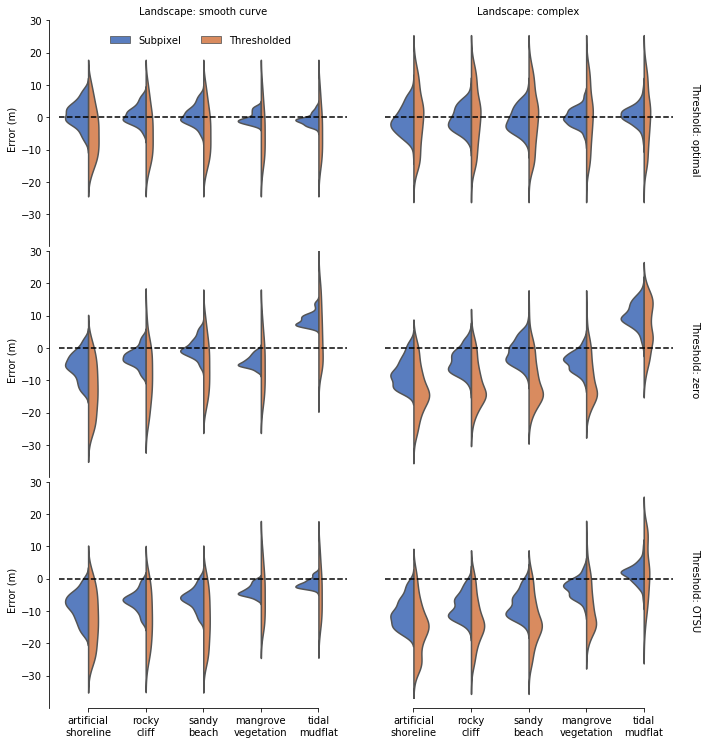

In [77]:
accuracy_results = pd.concat(output_dist_list)


# otsu
accuracy_results_otsu = accuracy_results[accuracy_results.otsu == True].copy()
accuracy_results_otsu['thresh'] = 'OTSU\n'
accuracy_results_zero = accuracy_results[accuracy_results.thresh == 0].copy()
accuracy_results_zero['thresh'] = 'zero\n'


# AWFUL
test = accuracy_results.groupby(['spectra', 'thresh', 'resolution', 'landscape', 'type']).apply(RMSE).reset_index()
optimal_threshes = test.loc[test.groupby(['spectra', 'resolution', 'landscape', 'type'])['Error (m)'].idxmin()]

out = []
for i in optimal_threshes.iterrows():
    out.append(accuracy_results[(accuracy_results.spectra == i[1].spectra) &
                                (accuracy_results.resolution == i[1].resolution) &
                                (accuracy_results.thresh == i[1].thresh) & 
                                (accuracy_results.type == i[1].type)])

accuracy_results_optimal = pd.concat(out)
accuracy_results_optimal['thresh'] = 'optimal\n'


# Merge all datasets into a single dataframe
accuracy_results_all = pd.concat([accuracy_results_optimal, accuracy_results_zero, accuracy_results_otsu])
accuracy_results_all['spectra'] = accuracy_results_all.spectra.str.replace('_', '\n')


#################
# Generate plot #
#################

# Determine nice plotting order for spectra (from lowest to highest mean)
x_order = list(accuracy_results_all.groupby('spectra').mean().sort_values('Error (m)').index)

g = sns.catplot(x="spectra", y="Error (m)", hue='type', data=accuracy_results_all, 
                col='landscape', row='thresh', height=3.5, aspect=1.4, palette="muted", 
                split=True, kind="violin", inner=None, scale='area', bw=0.33, order=x_order, 
                row_order=['optimal\n', 'zero\n', 'OTSU\n'], margin_titles=True)


##################
# Customise plot #
##################

# Set up named axes
(ax1, ax2), (ax3, ax4), (ax5, ax6)  = g.axes

# Bulk add horizontal 0 error line to all plots
[ax.axhline(0, color='black', linestyle='--') for ax in g.axes.flat]

# Remove axis labels from bottom facets
ax5.set_xlabel('')
ax6.set_xlabel('')

# Move facet titles to right and top of panels, and hide existing labels
[plt.setp(ax.texts, text="") for ax in g.axes.flat]
g.set_titles(row_template = 'Threshold: {row_name}', col_template = 'Landscape: {col_name}')

# Use nicer offset and trimmed axes
sns.despine(offset=10, trim=True)

# Remove axes lines and tickes from top facets
sns.despine(ax=ax1, bottom=True)
sns.despine(ax=ax2, left=True, bottom=True)
ax1.tick_params(axis='x', which='both',length=0)
ax2.tick_params(axis='both', which='both',length=0)

# Remove axes lines and tickes from middle facets
sns.despine(ax=ax3, bottom=True)
sns.despine(ax=ax4, left=True, bottom=True)
ax3.tick_params(axis='x', which='both',length=0)
ax4.tick_params(axis='both', which='both',length=0)

# Remove axes lines and tickes from bottom facets
sns.despine(ax=ax6, left=True)
ax6.tick_params(axis='y', which='both',length=0)

# Add extra white space between columns
plt.subplots_adjust(wspace=0.13)

# Make legend have two columns, and move to custom position
handles, labels = g.axes[0][0].get_legend_handles_labels()
g._legend.remove()
g.fig.legend(handles, labels, ncol=2, loc='upper center', 
                bbox_to_anchor=(0.25, 0.95), frameon=False)

# Set y limits
ax1.set_ylim(-37, 30)
ax2.set_ylim(-37, 30)


In [89]:
optimal_threshes.iloc[:,0:-2]
# pd.DataFrame({'resolution': np.arange(0,10, 1)})


,spectra,thresh,resolution,landscape,type
32,artificial_shoreline,-0.11,30,complex,Subpixel
13,artificial_shoreline,-0.16,30,complex,Thresholded
42,artificial_shoreline,-0.09,30,smooth curve,Subpixel
15,artificial_shoreline,-0.16,30,smooth curve,Thresholded
264,mangrove_vegetation,-0.14,30,complex,Subpixel
245,mangrove_vegetation,-0.19,30,complex,Thresholded
266,mangrove_vegetation,-0.14,30,smooth curve,Subpixel
239,mangrove_vegetation,-0.21,30,smooth curve,Thresholded
496,rocky_cliff,-0.07,30,complex,Subpixel
477,rocky_cliff,-0.12,30,complex,Thresholded


In [132]:
test = optimal_threshes.loc[np.repeat(optimal_threshes.index.values,30)]
test.loc[:,'resolution'] = np.tile(np.arange(1,31, 1), optimal_threshes.shape[0])
scenario_table = test.reset_index(drop=True).iloc[:,0:-2]
scenario_table 

,spectra,thresh,resolution,landscape,type
0,artificial_shoreline,-0.11,1,complex,Subpixel
1,artificial_shoreline,-0.11,2,complex,Subpixel
2,artificial_shoreline,-0.11,3,complex,Subpixel
3,artificial_shoreline,-0.11,4,complex,Subpixel
4,artificial_shoreline,-0.11,5,complex,Subpixel
5,artificial_shoreline,-0.11,6,complex,Subpixel
6,artificial_shoreline,-0.11,7,complex,Subpixel
7,artificial_shoreline,-0.11,8,complex,Subpixel
8,artificial_shoreline,-0.11,9,complex,Subpixel
9,artificial_shoreline,-0.11,10,complex,Subpixel


In [131]:
scenario_table.pivot(columns='type', values='thresh')

type,Subpixel,Thresholded
0,-0.11,NaN
1,-0.11,NaN
2,-0.11,NaN
3,-0.11,NaN
4,-0.11,NaN
5,-0.11,NaN
6,-0.11,NaN
7,-0.11,NaN
8,-0.11,NaN
9,-0.11,NaN


In [120]:
test.loc[:,'resolution'].shape

(600,)

In [121]:
np.tile(np.arange(0,31, 1), optimal_threshes.shape[0]).shape

(620,)

In [58]:
# test.groupby(['spectra', 'thresh', 'landscape', 'type']).apply(RMSE)['Error (m)']

spectra                thresh                landscape                type       
artificial\nshoreline  Threshold: OTSU\n     Landscape: smooth curve  Subpixel        9.488039
                                                                      Thresholded    15.009449
                                             Landscape: undulating    Subpixel       11.441311
                                                                      Thresholded    17.151632
                       Threshold: optimal\n  Landscape: smooth curve  Subpixel        3.977562
                                                                      Thresholded     8.688579
                                             Landscape: undulating    Subpixel        4.214447
                                                                      Thresholded     9.033773
                       Threshold: zero\n     Landscape: smooth curve  Subpixel        6.904142
                                                               

In [613]:
test

,spectra,thresh,resolution,landscape,type,error,otsu
0,artificial\nshoreline,Optimal threshold\n,30,Landscape: smooth curve,subpixel,-4.649747,False
1,artificial\nshoreline,Optimal threshold\n,30,Landscape: smooth curve,subpixel,-3.965970,False
2,artificial\nshoreline,Optimal threshold\n,30,Landscape: smooth curve,subpixel,-2.704625,False
3,artificial\nshoreline,Optimal threshold\n,30,Landscape: smooth curve,subpixel,-1.455934,False
4,artificial\nshoreline,Optimal threshold\n,30,Landscape: smooth curve,subpixel,-0.512569,False
5,artificial\nshoreline,Optimal threshold\n,30,Landscape: smooth curve,subpixel,-0.971077,False
6,artificial\nshoreline,Optimal threshold\n,30,Landscape: smooth curve,subpixel,-0.870029,False
7,artificial\nshoreline,Optimal threshold\n,30,Landscape: smooth curve,subpixel,-0.802229,False
8,artificial\nshoreline,Optimal threshold\n,30,Landscape: smooth curve,subpixel,-0.853963,False
9,artificial\nshoreline,Optimal threshold\n,30,Landscape: smooth curve,subpixel,-1.156148,False


In [594]:
ax1.get_legend_handles_labels()

([<matplotlib.patches.Rectangle at 0x7f89a695de80>,
 ['subpixel', 'threshold'])

In [531]:
test 

,spectra,thresh,resolution,landscape,type,error,otsu
0,artificial_shoreline,-0.1,30,beach,subpixel,-4.649747,False
1,artificial_shoreline,-0.1,30,beach,subpixel,-3.965970,False
2,artificial_shoreline,-0.1,30,beach,subpixel,-2.704625,False
3,artificial_shoreline,-0.1,30,beach,subpixel,-1.455934,False
4,artificial_shoreline,-0.1,30,beach,subpixel,-0.512569,False
5,artificial_shoreline,-0.1,30,beach,subpixel,-0.971077,False
6,artificial_shoreline,-0.1,30,beach,subpixel,-0.870029,False
7,artificial_shoreline,-0.1,30,beach,subpixel,-0.802229,False
8,artificial_shoreline,-0.1,30,beach,subpixel,-0.853963,False
9,artificial_shoreline,-0.1,30,beach,subpixel,-1.156148,False


/g/data/v10/public/modules/dea-env/20190522/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [526]:
accuracy_results_otsu.min()

spectra       artificial_shoreline
thresh                       -0.02
resolution                      30
landscape                    beach
type                      subpixel
error                     -32.8824
otsu                          True
dtype: object

In [473]:
optimal_threshes 

,spectra,thresh,resolution,landscape,type,error,otsu
40,tidal_mudflat,0.05,30,beach,subpixel,1.491408,0.0
45,tidal_mudflat,0.06,30,beach,threshold,8.688579,1.0
46,tidal_mudflat,0.06,30,cliff,subpixel,2.622346,0.0
47,tidal_mudflat,0.06,30,cliff,threshold,9.409999,0.0


In [468]:
accuracy_results

,spectra,thresh,resolution,landscape,type,error,otsu
0,sandy_beach,-0.15,30,beach,subpixel,11.965475,False
1,sandy_beach,-0.15,30,beach,subpixel,13.337658,False
2,sandy_beach,-0.15,30,beach,subpixel,14.703926,False
3,sandy_beach,-0.15,30,beach,subpixel,14.696686,False
4,sandy_beach,-0.15,30,beach,subpixel,14.310962,False
5,sandy_beach,-0.15,30,beach,subpixel,14.192903,False
6,sandy_beach,-0.15,30,beach,subpixel,14.123617,False
7,sandy_beach,-0.15,30,beach,subpixel,14.177770,False
8,sandy_beach,-0.15,30,beach,subpixel,14.075181,False
9,sandy_beach,-0.15,30,beach,subpixel,14.185238,False


,spectra,thresh,resolution,landscape,type,error,otsu
12,artificial_shoreline,-0.09,30,beach,subpixel,3.912446,0.0
5,artificial_shoreline,-0.15,30,beach,threshold,9.057007,0.0
10,artificial_shoreline,-0.12,30,cliff,subpixel,3.747279,0.0
7,artificial_shoreline,-0.15,30,cliff,threshold,9.757178,0.0
88,mangrove_vegetation,-0.15,30,beach,subpixel,1.795630,0.0
81,mangrove_vegetation,-0.21,30,beach,threshold,8.688579,0.0
90,mangrove_vegetation,-0.15,30,cliff,subpixel,2.602038,0.0
83,mangrove_vegetation,-0.21,30,cliff,threshold,9.409999,0.0
168,rocky_cliff,-0.06,30,beach,subpixel,2.871008,0.0
161,rocky_cliff,-0.12,30,beach,threshold,8.688579,0.0
